# Setup

In [22]:
from google.colab import drive
drive.mount('/content/drive')

!pip -q install torch torchvision pandas scikit-learn


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Imports

In [23]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix


In [24]:
TRAIN_DIR = Path("/content/drive/MyDrive/Train/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
TEST_DIR  = Path("/content/drive/MyDrive/Train/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

valid_ext = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# Build DataFrames

In [25]:
def build_df(root_dir: Path):
    rows = []
    for label_dir in root_dir.iterdir():
        if not label_dir.is_dir():
            continue
        label = label_dir.name
        for img_path in label_dir.rglob("*"):
            if img_path.is_file() and img_path.suffix.lower() in valid_ext:
                rows.append({"image": str(img_path), "label": label})
    return pd.DataFrame(rows)

train_df = build_df(TRAIN_DIR)
test_df  = build_df(TEST_DIR)

print("Train images:", len(train_df))
print("Test images:", len(test_df))
print("\nTrain label counts:\n", train_df["label"].value_counts())
print("\nTest label counts:\n", test_df["label"].value_counts())

Train images: 1801
Test images: 118

Train label counts:
 label
pigmented benign keratosis    462
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

Test label counts:
 label
melanoma                      16
dermatofibroma                16
nevus                         16
basal cell carcinoma          16
pigmented benign keratosis    16
actinic keratosis             16
squamous cell carcinoma       16
vascular lesion                3
seborrheic keratosis           3
Name: count, dtype: int64


#Labels Encoding

In [26]:
labels = sorted(train_df["label"].unique().tolist())
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}

train_df = train_df.copy()
train_df["label_id"] = train_df["label"].map(label2id)

test_df = test_df.copy()
test_df = test_df[test_df["label"].isin(label2id)].copy()
test_df["label_id"] = test_df["label"].map(label2id)

assert train_df["label_id"].isna().sum() == 0, "Train has unmapped labels."
assert test_df["label_id"].isna().sum() == 0, "Test has unmapped labels."

print("Num classes:", len(labels))
print("Train:", train_df.shape, " Test:", test_df.shape)
print("Label mapping:", label2id)


Num classes: 8
Train: (1801, 3)  Test: (102, 3)
Label mapping: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'nevus': 3, 'pigmented benign keratosis': 4, 'seborrheic keratosis': 5, 'squamous cell carcinoma': 6, 'vascular lesion': 7}


#Image Transforms

In [27]:
IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),])


#PyTorch Dataset

In [28]:
class SkinDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image"]
        label = int(self.df.loc[idx, "label_id"])

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

In [31]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_ds = SkinDataset(train_df, transform=train_tfms)
test_ds  = SkinDataset(test_df,  transform=test_tfms)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

train_x, train_y = next(iter(train_loader))
print("Train X:", train_x.shape)
print("Train y:", train_y.shape)

test_x, test_y = next(iter(test_loader))
print("Test X:", test_x.shape)
print("Test y:", test_y.shape)


Train X: torch.Size([32, 3, 224, 224])
Train y: torch.Size([32])
Test X: torch.Size([32, 3, 224, 224])
Test y: torch.Size([32])


# Saving the tensors

In [32]:
import torch

def collect_all(loader):
    xs, ys = [], []
    for x, y in loader:
        xs.append(x.cpu())
        ys.append(y.cpu())
    return torch.cat(xs, dim=0), torch.cat(ys, dim=0)

train_X, train_y = collect_all(train_loader)
test_X,  test_y  = collect_all(test_loader)

print("Train X:", train_X.shape, "Train y:", train_y.shape)
print("Test  X:", test_X.shape,  "Test  y:",  test_y.shape)


torch.save(
    {
        "X": train_X,
        "y": train_y
    },
    "isic_train_xy.pt"
)

torch.save(
    {
        "X": test_X,
        "y": test_y
    },
    "isic_test_xy.pt")

print("Saved train/test tensors successfully.")


Train X: torch.Size([1801, 3, 224, 224]) Train y: torch.Size([1801])
Test  X: torch.Size([102, 3, 224, 224]) Test  y: torch.Size([102])
Saved train/test tensors successfully.


#Sanity Check: 5 Random Images

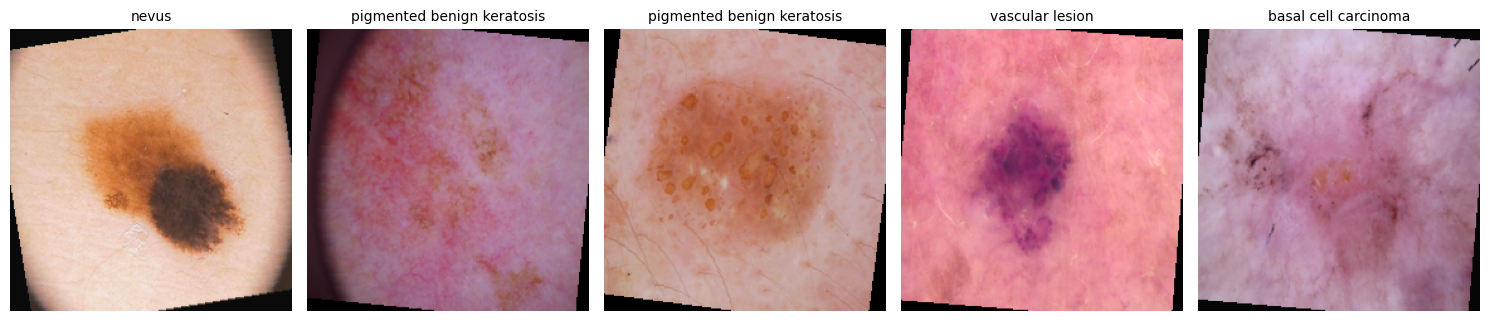

In [30]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def unnormalize(img_tensor):
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
    return img.clamp(0, 1)

images, labels = next(iter(train_loader))  # <-- THIS WAS MISSING

fig, axes = plt.subplots(1, 5, figsize=(15, 4))

idxs = random.sample(range(len(images)), 5)

for ax, idx in zip(axes, idxs):
    img = unnormalize(images[idx]).permute(1, 2, 0).cpu().numpy()
    label_id = labels[idx].item()
    label_name = id2label[label_id]

    ax.imshow(img)
    ax.set_title(label_name, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()
